# Analysis of the Heat Capacity of an Unknown Substance Using the Debye and Quantum Free Electron Models

## Introduction
The rate at which the internal energy of a substance changes with increasing temperature is called its heat capacity. More formally, the molar heat capacity $C_v$ is defined with the following,

$
\begin{equation}
\displaystyle C_v = \frac{\partial E}{\partial T}
\end{equation}
$

where E is the internal energy of a mol of the substance, and T is its temperature. To calculate the heat capacity, we need to model how the energy of the components of the substance depends on temperature. In the case of metals, the primary contributors to the heat capacity are the metal's lattice and electrons, and their temperature energy dependence can be approximated with the Debye model and the quantum free electron model, respectively.

The heat capacity in the quantum free electron model is given by:

$
\begin{equation}
\displaystyle C_v = \int_0^{\infty} E\ g(E)\ \frac{\partial f(E)}{\partial T}\ dE
\end{equation}
$

where $E$ is the free-electron energy, $g(E)$ is the density of states, and $f(E)$ is the Fermi-Dirac distribution. For the debye model, the molar heat capacity is given by:

$
\begin{equation}
\displaystyle C_v = 9 N_a k_b \Big(\frac{T}{\Theta_D}\Big)^3 \int_0^{\Theta_D/T} \frac{x^4e^x}{(e^x - 1)^2} dx
\end{equation}
$

where $x = \hbar\omega/k_bT$ and $\Theta_D = \hbar\omega_D/k_b$. Both of the above integrals cannot be solved analytically—numerical integration is required to obtain the heat capacity.

In this paper, we use the models described above to determine the theoretical heat capacity of an unknown substance and compare it to experimental data. However, before computing the theoretical heat capacity of the substance, we determine its Fermi energy and Debye temperature using the experimental heat capacity data. Python is used to perform this analysis, and we start by importing all required libraries:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.constants as const
import scipy.integrate as integrate
import IPython.display as disp
plt.style.use('fivethirtyeight')

## Analyze Heat Capacity Data From an Unknown Substance
The heat capacity data for our unknown substance is stored in the file `heat_capacity.csv`. We first import this data using pandas and rename the columns for more convienient indexing:

In [2]:
data = pd.read_csv('heat_capacity.csv')
disp.display(data.head())
data.columns = ['temp', 'cv']

,temperature (K),heat capacity (J mol^-1 K^-1)
0,1.00,0.00074
1,1.76,0.00147
2,1.87,0.00159
3,2.00,0.00177
4,2.16,0.00198


We plot the data to get a sense of what it looks like,

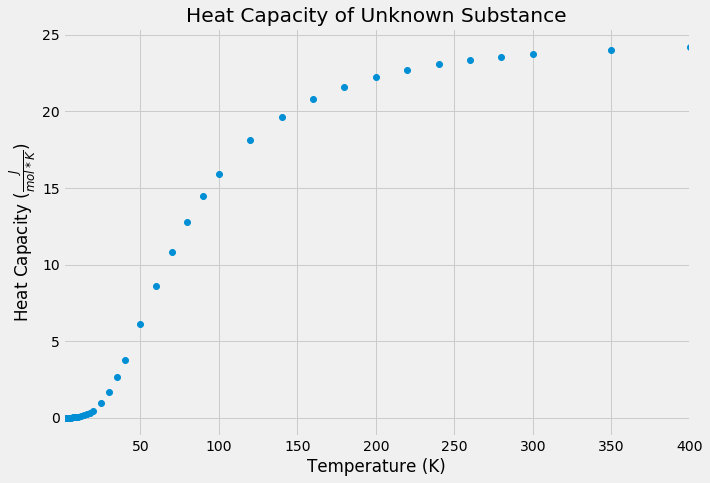

In [3]:
data.plot(x='temp', y='cv', title='Heat Capacity of Unknown Substance', legend=False, style='o', figsize=(10, 7))
plt.xlabel('Temperature (K)')
plt.ylabel('Heat Capacity ($\\frac{J}{mol * K}$)')

In order to compute the theoretical heat capacity of this substance using the Debye and quantum free electron models, we need to determine two of its physical constants, the Fermi energy, $E_f$ and the Debye temperature, $\Theta_D$. This is accomplished by taking the low temperature limits of equations (2) and (3).

For the quatum free electron model, the heat capacity at low temperature can be approximated with [1],

$
\begin{equation}
\displaystyle C_v = \frac{\pi^2}{2}\frac{N_a}{E_f}k_b^2T
\end{equation}
$

Similarly, we can model the Debye heat capacity at low temperature with [1],

$
\begin{equation}
\displaystyle C_v = \frac{12\pi^4}{5}N_ak_b\Big(\frac{T}{\Theta_D}\Big)^3
\end{equation}
$

Since we expect the substance's heat capacity the be the sum of the electronic and lattice heat capacities, we can find a replationship for the total heat capacity,

$
\begin{equation}
\displaystyle \frac{C_v}{T} = \Big[\frac{\pi^2}{2}\frac{N_a}{E_f}k_b^2T\Big] + \Big[\frac{12\pi^4}{5\Theta_D^3}N_ak_b\ T^2 \Big]
\end{equation}
$

Using the above relationship, we can fit a line to $\frac{C_v}{T}$ versus $T^2$ to find the Debye temperature and Fermi energy of the substance. For this analysis, we use the data that is below 5 K so that the temperature is sufficiently low for the approximations:

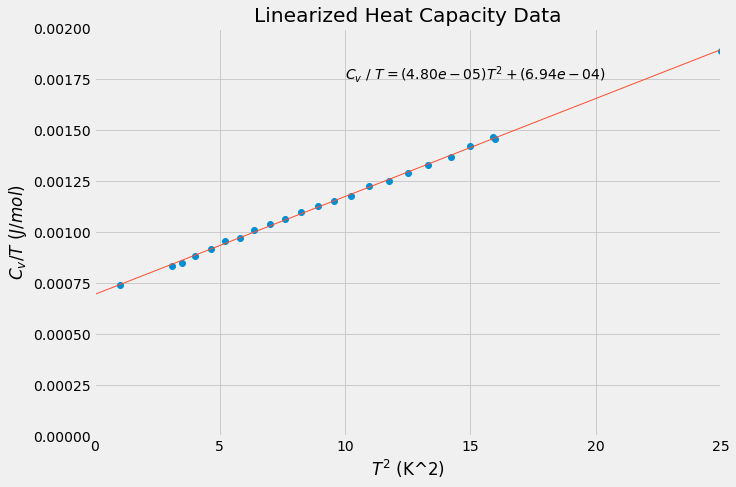

In [4]:
MAX_TEMP = 5 # Kelvin

data['temp_sq'] = data['temp']**2
data['cv/temp'] = data['cv'] / data['temp']

# Fit a line to the low temp data
low_t = data.loc[data['temp'] < MAX_TEMP]
slope, intc = np.polyfit(low_t['temp_sq'], low_t['cv/temp'], 1)

# Plot the data and the fit line
data.plot(x='temp_sq', y='cv/temp', xlim=(0, MAX_TEMP**2), ylim=(0, 0.002),
          title='Linearized Heat Capacity Data', legend=False, figsize=(10, 7), style='o')
x = np.linspace(0, MAX_TEMP**2)
plt.plot(x, slope*x + intc, linewidth=1)
plt.xlabel('$T^2$ (K^2)')
plt.ylabel('$C_v/T$ ($J/mol$)')
plt.gca().text(10, 0.00175, '$C_v\ /\ T = ({:.2e})T^2 + ({:.2e})$'.format(slope, intc))

We can now use equation (6) with the slope and intercept of the fit line to find the Fermi energy and the Debye temperature:

In [30]:
fermi_energy = const.pi**2 * 2 * const.Avogadro * const.Boltzmann**2 / (2 * intc)
debye_temp = (12 * const.pi**4 * const.Avogadro * const.Boltzmann / (5 * slope))**(1/3)

disp.display(disp.Latex('Debye Temp = $\Theta_D = {:.1f}$ K'.format(debye_temp)))
disp.display(disp.Latex('Fermi Temp = $\Theta_D = {:.2e}$ K'.format(fermi_energy / (const.Boltzmann))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

With the Debye temperature and Fermi energy in hand, we can move to numerically integrating the two heat capacity equations. We start with the electron contribution to the heat capcity.

$
\begin{equation}
\displaystyle C_v = \int_0^\infty \frac{3N_a}{2E_f^{3/2}}E^{3/2}\ \frac{\partial f(E, T)}{\partial T} dE
\end{equation}
$

where,

$
\begin{equation}
\displaystyle \frac{\partial f(E, T)}{\partial T} = \frac{E - E_f}{k_bT^2}\frac{e^{(E-Ef)/k_bT}}{(e^{(E-Ef)/k_bT} + 1)^2}
\end{equation}
$

Combining these equations and substituting $x = \frac{E}{k_bT}$ and $C = \frac{E_f}{k_bT}$, we obtain,

$
\begin{equation}
\displaystyle C_v = \frac{3N_ak_b^{5/2}}{2E_f^{3/2}} T^{3/2} \int_0^\infty x^{3/2} (x-C)\frac{e^{x-C}}{(e^{x-C} + 1)^2}dx
\end{equation}
$

We can define a function for the integrand above.

In [31]:
def qfem_integrand(x, C):
    # Hack to prevent buffer overflows
    p = x - C
    if (p > 709):
        print('zero')
        v = 0
    else:
        v = np.exp(x-C) / (np.exp(x-C) + 1)**2
    return x**(3/2) * p * v

This quantity needs to be integrated from $E=0$ to $E=\infty$ for every value of T we're interested in. To perform this integration, we define a function that uses `scipy.integrate.quad`:

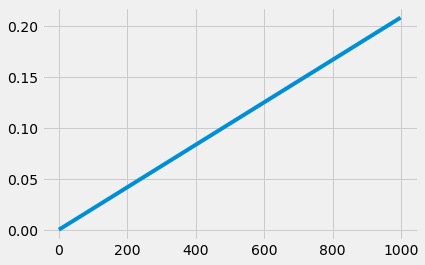

In [32]:
FERMI_ENERGY = fermi_energy

def electron_heat_capacity(T, Ef):
    cv = np.zeros_like(T, dtype='float64')
    coef = 3 * const.Avogadro * const.Boltzmann**(5/2) / (2 * Ef**(3/2))
    
    for i,t in np.ndenumerate(T):
        C = Ef / (const.Boltzmann * t)
        lower = C - 40 if C - 40 > 0 else 0
        v,_ = integrate.quad(qfem_integrand, lower, C+100, args=(C))
        cv[i] = coef * t**(3/2) * v
    return cv

temps = np.linspace(1, 400, 1000, dtype='float64')
electron_cv = electron_heat_capacity(temps, FERMI_ENERGY)
plt.plot(electron_cv)

Similarly, for the Debye model, the integrand, $I$, is

$
\begin{equation}
\displaystyle I = 9 N_a k_b \Big(\frac{T}{\Theta_D}\Big)^3 \frac{x^4e^x}{(e^x - 1)^2} dx
\end{equation}
$

where,

$
\begin{equation}
\displaystyle x = \frac{\hbar \omega}{k_bT}
\end{equation}
$

In [33]:
def debye_integrand(x, T, T_debye):
    return 9 * const.Avogadro * const.Boltzmann * T**3 * x**4 * np.exp(x) / (T_debye**3 * (np.exp(x) - 1)**2)

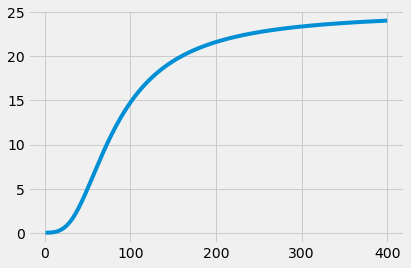

In [34]:
DEBYE_TEMP = debye_temp

def debye_heat_capacity(T, T_debye):
    cv = np.zeros_like(T, dtype='float64')
    
    for i,t in np.ndenumerate(T):
        cv[i],_ = integrate.quad(debye_integrand, 0, T_debye / t, args=(t, T_debye))
    return cv

debye_cv = debye_heat_capacity(temps, DEBYE_TEMP)
plt.plot(temps, debye_cv)

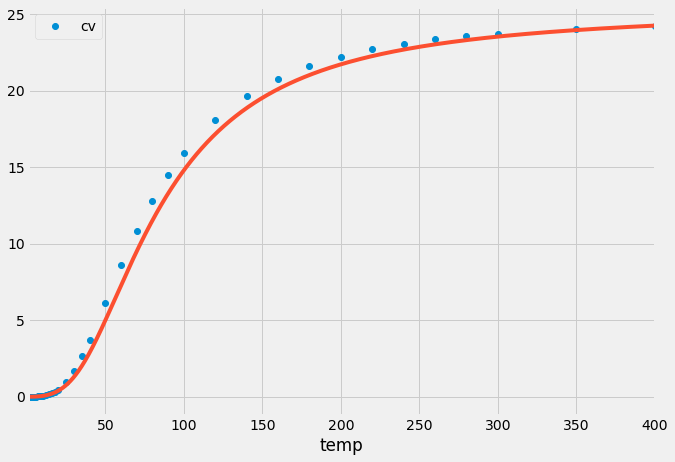

In [38]:
data.plot(x = 'temp', y='cv', style='o', figsize=(10,7))
plt.plot(temps, debye_cv + electron_cv)

[-1, 5, 0, 0.01]

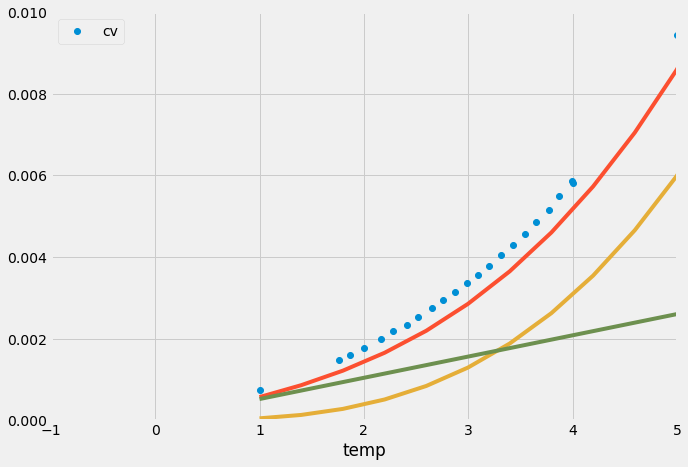

In [37]:
data.plot(x = 'temp', y='cv', style='o', figsize=(10,7))
plt.plot(temps, debye_cv + electron_cv)
plt.plot(temps, debye_cv)
plt.plot(temps, electron_cv)

plt.axis([-1, 5, -0, 0.01])

[1] Philip Hofmann. *Solid State Physics: An Introduction*. Wiley, 2015.